# MiniTensor Serialization, Plugins, Custom Ops & NumPy Compatibility

This notebook covers the remaining public APIs: serialization helpers, custom operations, plugin utilities, and the NumPy compatibility module.


In [1]:
import minitensor as mt
from minitensor import nn
from minitensor import serialization, plugins, numpy_compat
import numpy as np
import matplotlib.pyplot as plt
import tempfile
from pathlib import Path

mt.manual_seed(21)
np.random.seed(21)


## Custom operations API

In [2]:
if hasattr(mt, "register_example_custom_ops"):
    mt.register_example_custom_ops()
    ops = mt.list_custom_ops_py()
    print("registered ops:", ops)
    print("swish registered?", mt.is_custom_op_registered_py("swish"))

    x = mt.randn(2, 3)
    print("swish:")
    print(mt.execute_custom_op_py("swish", [x]))
    print("gelu:")
    print(mt.execute_custom_op_py("gelu", [x]))
    print("mish:")
    print(mt.execute_custom_op_py("mish", [x]))

    base = mt.tensor([2.0, 3.0])
    exp = mt.tensor([3.0, 2.0])
    print("power:")
    print(mt.execute_custom_op_py("power", [base, exp]))

    weight = mt.ones(3)
    bias = mt.zeros(3)
    print("layer_norm:")
    print(mt.execute_custom_op_py("layer_norm", [x, weight, bias]))

    mt.unregister_custom_op_py("swish")
    print("swish registered after unregister?", mt.is_custom_op_registered_py("swish"))

    # Restore example ops for other notebooks
    mt.register_example_custom_ops()
else:
    print("Custom operation bindings are not available in this build.")


Custom operation bindings are not available in this build.


## Serialization utilities

In [3]:
model = nn.Sequential([
    nn.DenseLayer(4, 3),
    nn.ReLU(),
    nn.DenseLayer(3, 2),
])

state = model.state_dict()
metadata = serialization.ModelMetadata("demo_model", "Sequential")
metadata.description = "Tiny demo model for serialization"
metadata.add_input_shape([1, 4])
metadata.add_output_shape([1, 2])
metadata.add_custom("framework", "minitensor")

serialized = serialization.SerializedModel(metadata, state)
serialized.architecture_config = "dense-relu-dense"
serialized.check_compatibility()

print("metadata name:", serialized.metadata.name)
print("state param names:", serialized.state_dict.parameter_names())
print("architecture config:", serialized.architecture_config)

fmt = serialization.SerializationFormat.json()
with tempfile.TemporaryDirectory() as tmpdir:
    tmp_path = Path(tmpdir)
    json_path = tmp_path / "serialized_model.json"
    bin_path = tmp_path / "serialized_model.bin"

    serialization.ModelSerializer.save(serialized, str(json_path), fmt)
    reloaded = serialization.ModelSerializer.load(str(json_path), fmt)
    print("reloaded:", reloaded)

    serialization.save_model(serialized, str(bin_path), "bin")
    print("save_model/load_model:", serialization.load_model(str(bin_path), "bin"))

    # Deployment model helpers
    deployment = reloaded.to_deployment_model()
    deployment.add_inference_config("precision", "fp32")
    print("deployment model:", deployment)


metadata name: demo_model
state param names: ['param_0', 'param_1', 'param_3', 'param_2']
architecture config: dense-relu-dense
reloaded: SerializedModel(name='demo_model')
save_model/load_model: SerializedModel(name='demo_model')
deployment model: DeploymentModel(name='demo_model', version='1.0.0')


## Module save/load helpers

In [4]:
with tempfile.TemporaryDirectory() as tmpdir:
    tmp_path = Path(tmpdir)
    state_path = tmp_path / "module_state.bin"

    model.save(str(state_path), "bin")
    state_from_disk = nn.Module.load_state_from(str(state_path), "bin")
    print("loaded state dict:", state_from_disk)

    fresh_model = nn.Sequential([
        nn.DenseLayer(4, 3),
        nn.ReLU(),
        nn.DenseLayer(3, 2),
    ])

    fresh_model.load_state_dict(state_from_disk, mt.cpu())
    print("fresh model num params:", fresh_model.num_parameters())


loaded state dict: StateDict(4 parameters, 0 buffers)
fresh model num params: 23


## Plugin system

In [5]:
current_version = plugins.VersionInfo.current()
parsed = plugins.VersionInfo.parse("1.2.3")
print("current version:", current_version)
print("parsed version:", parsed)
print("compatible?", current_version.is_compatible_with(parsed))

builder = (
    plugins.PluginBuilder()
    .name("example_plugin")
    .version(plugins.VersionInfo(1, 0, 0))
    .description("Example plugin for notebook demo")
    .author("MiniTensor Team")
    .min_minitensor_version(plugins.VersionInfo(0, 1, 0))
)
plugin = builder.build()
print("plugin info:", plugin.info)

registry = plugins.PluginRegistry()
registry.register(plugin)
print("registered plugins:", registry.list_plugins())
print("is registered:", registry.is_registered("example_plugin"))

loaded_plugin = registry.get_plugin("example_plugin")
print("loaded plugin info:", loaded_plugin.info)

registry.unregister("example_plugin")
print("is registered after unregister:", registry.is_registered("example_plugin"))

custom_layer = plugins.CustomLayer("Normalization")
custom_layer.add_parameter("scale", mt.ones(3))
custom_layer.set_forward(lambda inputs: inputs[0] / inputs[0].max())

layer_out = custom_layer.forward([mt.tensor([1.0, 2.0, 3.0])])
print("custom layer parameters:", custom_layer.list_parameters())
print("custom layer output:", layer_out)

print("loaded engine plugins:", plugins.list_plugins())
print("is plugin loaded?", plugins.is_plugin_loaded("example_plugin"))


current version: 0.1.3
parsed version: 1.2.3
compatible? False
plugin info: example_plugin v1.0.0 by MiniTensor Team
registered plugins: [PluginInfo(name='example_plugin', version='1.0.0', author='MiniTensor Team')]
is registered: True
loaded plugin info: example_plugin v1.0.0 by MiniTensor Team
is registered after unregister: False
custom layer parameters: ['scale']
custom layer output: tensor([0.3333333432674408, 0.6666666865348816, 1.0])
loaded engine plugins: []
is plugin loaded? False


## NumPy compatibility module

In [6]:
a = mt.arange(0, 6).reshape(2, 3)
b = mt.ones(2, 3)

print("asarray:", numpy_compat.asarray([1, 2, 3]))
print("concatenate:", numpy_compat.concatenate([a, b], axis=0))
print("stack:", numpy_compat.stack([a, b], axis=0))
print("split:", numpy_compat.split(a, 3, axis=1))
print("hsplit:", numpy_compat.hsplit(a, 3))
print("vsplit:", numpy_compat.vsplit(a, 2))
print("hstack:", numpy_compat.hstack([a, b]))
print("vstack:", numpy_compat.vstack([a, b]))
print("zeros_like:", numpy_compat.zeros_like(a))
print("ones_like:", numpy_compat.ones_like(a))
print("empty_like:", numpy_compat.empty_like(a))
print("full_like:", numpy_compat.full_like(a, 9.0))
print("dot:", numpy_compat.dot(mt.tensor([1.0, 2.0]), mt.tensor([3.0, 4.0])))
print("matmul:", numpy_compat.matmul(a, b.transpose(0, 1)))
print("sum:", numpy_compat.sum(a))
print("mean:", numpy_compat.mean(a))
print("prod:", numpy_compat.prod(a))
print("var:", numpy_compat.var(a))
print("tensor_std:", numpy_compat.tensor_std(a))
print("max:", numpy_compat.max(a))
print("min:", numpy_compat.min(a))
print("nanmax:", numpy_compat.nanmax(a))
print("nanmean:", numpy_compat.nanmean(a.astype("float32")))
print("nanmin:", numpy_compat.nanmin(a.astype("float32")))
print("nansum:", numpy_compat.nansum(a))
print("where:", numpy_compat.where(a > 2, a, mt.zeros_like(a)))
print("cross:", numpy_compat.cross(mt.tensor([1.0, 0.0, 0.0]), mt.tensor([0.0, 1.0, 0.0])))


asarray: tensor([1.0, 2.0, 3.0])
concatenate: tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [1.0, 1.0, 1.0], [1.0, 1.0, 1.0]])
stack: tensor([[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0]], [[1.0, 1.0, 1.0], [1.0, 1.0, 1.0]]])
split: [Tensor(shape=[2, 1], dtype=float32, device=cpu, requires_grad=false), Tensor(shape=[2, 1], dtype=float32, device=cpu, requires_grad=false), Tensor(shape=[2, 1], dtype=float32, device=cpu, requires_grad=false)]
hsplit: [Tensor(shape=[2, 1], dtype=float32, device=cpu, requires_grad=false), Tensor(shape=[2, 1], dtype=float32, device=cpu, requires_grad=false), Tensor(shape=[2, 1], dtype=float32, device=cpu, requires_grad=false)]
vsplit: [Tensor(shape=[1, 3], dtype=float32, device=cpu, requires_grad=false), Tensor(shape=[1, 3], dtype=float32, device=cpu, requires_grad=false)]
hstack: tensor([[0.0, 1.0, 2.0, 1.0, 1.0, 1.0], [3.0, 4.0, 5.0, 1.0, 1.0, 1.0]])
vstack: tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [1.0, 1.0, 1.0], [1.0, 1.0, 1.0]])
zeros_like: tensor([[0.0, 0.0, 0.0], 

## Visualization: parameters histogram

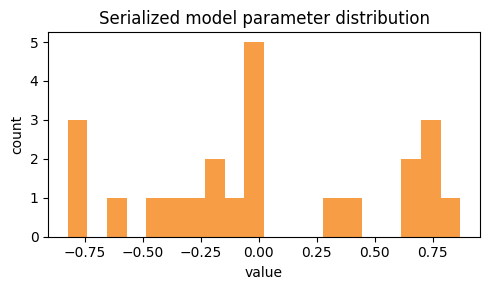

In [7]:
params = []
for param in model.parameters():
    params.extend(param.ravel().tolist())

plt.figure(figsize=(5, 3))
plt.hist(params, bins=20, color="#f58518", alpha=0.8)
plt.title("Serialized model parameter distribution")
plt.xlabel("value")
plt.ylabel("count")
plt.tight_layout()
plt.show()
